## NOTE: This notebook provides an example for the design of *single-guide* libraries in CROPseq-multi, not dual-guide libraries!

This is a non-standard use of CROPseq-multi! **For most applications, including single-gene targeting and combinatorial libraries, we strongly recommend using dual-guide constructs for superior screening performance.** For examples of dual-guide designs, please see the appropriate jupyter notebooks in this repository.

In special cases when the screener wants only a single guide per construct, CROPseq-multi can be used analagously to a standard CROPseq vector, with some additional functionalities that may be useful, including iBARs and barcode detection features. Note that these designs will require alterations to the molecular cloning, sequencing, and CRISPR screening protocols that have been developed for dual-guide constructs.

Until ourselves and others have more fully developed these protocols, this approach is **not yet recommended for general use.**

In [1]:
import sys
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob


In [2]:
# provide the path to your local installation of the CROPseq-multi package
CSM_dir = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/csm')

import guide_selection, barcode_selection, oligo_design

# overview

1) **select sgRNA spacers** 

2) **select iBARs** 

3) **generate oligos**

# 1. select sgRNA spacer pairs

### Load selected sgRNAs 

For an example, here the input to our pipeline is a set of guides designed for base editor tiling of BCL2 (from  Sangree, Griffith et al. 2022, supplementary table 7)

In [3]:
# provide the path to your CRISPick guide design
guide_input_df = pd.read_csv('input_files/example_tiling_screen_guides.csv')
guide_input_df

,sgRNA sequence,sgRNA context sequence,Gene symbol,sgrna genomic position,sgRNA Strand,PAM,Edit,Nucleotide edits,Amino acid edits,Mutation category
0,AAAACGACCACCCGAAACCT,NaN,ONE_NON-GENE_SITE,NaN,NaN,NaN,NaN,NaN,ONE_NON-GENE_SITE,ONE_NON-GENE_SITE
1,AAACAGAGGCCGCATGCTGG,AATCAAACAGAGGCCGCATGCTGGGGCCGT,BCL2,63128715.0,antisense,GGCC,C-T,C_4,Leu209Leu,Silent
2,AAACTGAGCAGAGTCTTCAG,GGCCAAACTGAGCAGAGTCTTCAGAGACAG,BCL2,63128677.0,antisense,AGAC,C-T,C_4,Ser222Asn,Missense
3,AAAGCGTCCCCGCGCGGTGA,TGGCAAAGCGTCCCCGCGCGGTGAAGGGCG,BCL2,63318277.0,antisense,AGGG,C-T,"C_8, C_5","Gly128Glu, Arg129His","Missense, Missense"
4,AAAGCTATTTATCGCGTCGT,NaN,NO_SITE,NaN,NaN,NaN,NaN,NaN,NO_SITE,NO_SITE
...,...,...,...,...,...,...,...,...,...,...
869,TTGTGGCCCAGATAGGCACC,TCACTTGTGGCCCAGATAGGCACCCAGGGT,BCL2,63128629.0,antisense,CAGG,C-T,C_8_7,Gly237Asn,Missense
870,TTGTGGCCTTCTTTGAGTTC,AGGATTGTGGCCTTCTTTGAGTTCGGTGGG,BCL2,63318208.0,sense,GGTG,C-T,C_7_8,Ala149Val,Missense
871,TTGTTTGGGGCAGGCATGTT,ATATTTGTTTGGGGCAGGCATGTTGACTTC,BCL2,63128601.0,antisense,GACT,C-T,NaN,NaN,NaN
872,TTTCTCCTGGCTGTCTCTGA,TTGATTTCTCCTGGCTGTCTCTGAAGACTC,BCL2,63128693.0,sense,AGAC,C-T,"C_4, C_6_7","Phe212Phe, Ser213Phe","Silent, Missense"


/Users/rwalton/Documents/CROPseq-multi/csm/guide_selection.py:560: UserWarning: Pick Order column not found in input df. No prioritization will be used.
  warnings.warn('Pick Order column not found in input df. No prioritization will be used.')


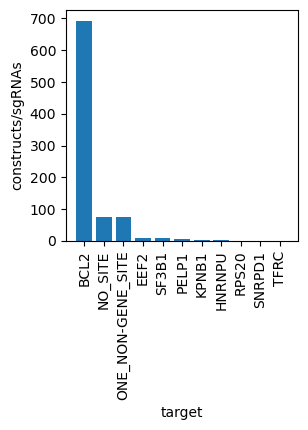

In [4]:
# essentially just filtering the input df for sgRNAs to avoid BsmBI sites, pol III terminators ("TTTT")

tiling_guides = guide_selection.select_single_guides_CRISPick(
    guide_input_df, 
    constructs_per_gene = 'all', # int or 'all' to select all compatible guides
    target_col = 'Gene symbol',
    spacer_col = 'sgRNA sequence',
)

tiling_guides['category']='GENE_TARGETING'

plt.figure(figsize=(3,3))
plt.bar(tiling_guides.value_counts('target').index, tiling_guides.value_counts('target').values)
plt.xlabel('target')
plt.xticks(rotation=90)
plt.ylabel('constructs/sgRNAs')
plt.show()

# 2. iBAR selection

### pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)
- barcodes are not necessarily compatible across these sets
- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [5]:
# import all the barcode sets
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n6_k3_Levenshtein.noBsmBI.csv,6.0,3.0,Levenshtein,87.0
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n6_k2_Levenshtein.noBsmBI.csv,6.0,2.0,Levenshtein,883.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0


In [6]:
library_design_df = barcode_selection.select_and_complete_individual_barcodes(
    tiling_guides, 
    distance=3, 
)
library_design_df


Edit distance 3 in 9 cycles
generating and filtering complete iBARs


100%|██████████| 3054/3054 [00:00<00:00, 6142.68it/s]

sequencing requirements:
barcodes are unique in:
 7 cycles


,target,spacer,pick_order,target_version,category,iBAR
0,BCL2,AAACAGAGGCCGCATGCTGG,0,1,GENE_TARGETING,AAATACGAGAAG
1,BCL2,GGAGGATTGTGGCCTTCTTT,0,2,GENE_TARGETING,TCAACGCGGCTT
2,BCL2,GGAGGCTGGGTAGGTGCACT,0,3,GENE_TARGETING,TGCATGCGCCAC
3,BCL2,GGAGGGTCAGGTGGACCACA,0,4,GENE_TARGETING,ATTGTGATGCTA
4,BCL2,GGATCCAGGATAACGGAGGC,0,5,GENE_TARGETING,CACAAGTCAAAT
...,...,...,...,...,...,...
869,SF3B1,GGACTTACCTTTCTCATTGG,0,7,GENE_TARGETING,CACCTCTTGACT
870,SF3B1,GTACTACCTTATATCCTTCT,0,8,GENE_TARGETING,CTCTAAATGTGT
871,SF3B1,TGTACTACCTTATATCCTTC,0,9,GENE_TARGETING,GAGCCTTAGAGC
872,SNRPD1,CCGTACCTGTGATTGTTCCA,0,1,GENE_TARGETING,ATTTGACCCAGG


# 3. generate oligos

- successful oligo designs will populate the 'oligo' column in oligo_design_df
- if any oligos were not successfully built, those rows will be returned in 'df_failed' for inspesction
  - if all oligos were successfully built, 'df_failed' will be an empty dataframe


In [7]:
oligo_design_df, df_failed = oligo_design.build_CROPseq_multi_single_guide_oligos(library_design_df)

In [8]:
# inspect any designs for which oligos could not be built
# (empty dataframe if there were no failures)
df_failed

""


In [9]:
# successful designs
oligo_design_df

,target,spacer,pick_order,target_version,category,iBAR,dialout,dialout_fwd,dialout_rev,oligo,oligo_len
0,BCL2,AAACAGAGGCCGCATGCTGG,0,1,GENE_TARGETING,AAATACGAGAAG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAAAACAGAGGCCGCATGCTGG...,102
1,BCL2,GGAGGATTGTGGCCTTCTTT,0,2,GENE_TARGETING,TCAACGCGGCTT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGGAGGATTGTGGCCTTCTTT...,102
2,BCL2,GGAGGCTGGGTAGGTGCACT,0,3,GENE_TARGETING,TGCATGCGCCAC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGGAGGCTGGGTAGGTGCACT...,102
3,BCL2,GGAGGGTCAGGTGGACCACA,0,4,GENE_TARGETING,ATTGTGATGCTA,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGGAGGGTCAGGTGGACCACA...,102
4,BCL2,GGATCCAGGATAACGGAGGC,0,5,GENE_TARGETING,CACAAGTCAAAT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGGATCCAGGATAACGGAGGC...,102
...,...,...,...,...,...,...,...,...,...,...,...
869,SF3B1,GGACTTACCTTTCTCATTGG,0,7,GENE_TARGETING,CACCTCTTGACT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGGACTTACCTTTCTCATTGG...,102
870,SF3B1,GTACTACCTTATATCCTTCT,0,8,GENE_TARGETING,CTCTAAATGTGT,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCAGTACTACCTTATATCCTTCT...,102
871,SF3B1,TGTACTACCTTATATCCTTC,0,9,GENE_TARGETING,GAGCCTTAGAGC,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCATGTACTACCTTATATCCTTC...,102
872,SNRPD1,CCGTACCTGTGATTGTTCCA,0,1,GENE_TARGETING,ATTTGACCCAGG,0,CCGGCCAACATACC,CTCGTTCCTTTCGA,CCGGCCAACATACCCGTCTCAATGCACCGTACCTGTGATTGTTCCA...,102


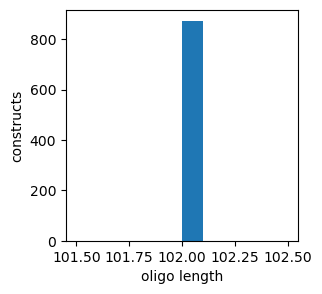

In [10]:
plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

### save the designs and order the 'oligo' for molecular cloning

In [ ]:
# oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")),index=False)
# oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))